<a href="https://colab.research.google.com/github/levchenkopavlo/AI/blob/master/%D0%94%D0%97_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [ ]:
import torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [ ]:
device

'cpu'

Дані медичне страхування

In [ ]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/insurance.csv')

df['sex'] = df['sex'].map({'male': 0, 'female':1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes':1})

df = df.drop(columns=['region'])

data = df[['age', 'bmi', 'expenses']]
df[['age', 'bmi', 'expenses']] = (data - data.min()) / (data.max() - data.min())

In [ ]:
df.head()

,age,sex,bmi,children,smoker,expenses
0,0.021739,1,0.320755,0,1,0.251611
1,0.000000,0,0.479784,1,0,0.009636
2,0.217391,0,0.458221,3,0,0.053115
3,0.326087,0,0.180593,0,0,0.333010
4,0.304348,0,0.347709,0,0,0.043816


In [ ]:
print('dimensions: ', df.shape, end='\n\n')
print(df.columns, end='\n\n')
print('types of columns:\n',df.dtypes, end='\n\n', sep='')
print('missing values:\n', df.isnull().sum().to_string(), end='\n\n', sep='')
df.describe()

dimensions:  (1338, 6)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'expenses'], dtype='object')

types of columns:
age         float64
sex           int64
bmi         float64
children      int64
smoker        int64
expenses    float64
dtype: object

missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
expenses    0



,age,sex,bmi,children,smoker,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.494768,0.395296,1.094918,0.204783,0.193916
std,0.305434,0.500160,0.164377,1.205493,0.403694,0.193301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195652,0.000000,0.277628,0.000000,0.000000,0.057757
50%,0.456522,0.000000,0.388140,1.000000,0.000000,0.131849
75%,0.717391,1.000000,0.504043,2.000000,0.000000,0.247700
max,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000


Потрібно на основі інформації людини спрогнозувати розмір її страховки `expenses`

# Завдання 1
Створіть клас Dataset

In [ ]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values).to(device)
      self.y = torch.FloatTensor(y.values).to(device)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['expenses'])
y = df['expenses']

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset,  # датасет з даними
                        batch_size=batch_size,  # кількість даних в одному пакеті
                        shuffle=True,  # чи треба перемішувати дані
                        generator=torch.Generator(device=device)) # підключення до процесора)

In [ ]:
X_batch, y_batch = next(iter(dataloader))

print(f'{X_batch.shape=}')
print(f'{y_batch.shape=}')
print(f'{X_batch.device=}')

X_batch.shape=torch.Size([128, 5])
y_batch.shape=torch.Size([128, 1])
X_batch.device=device(type='cpu')


# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-5
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [ ]:
from torch import nn


model = nn.Sequential(
    nn.Linear(5, 10),
    nn.Sigmoid(),
    nn.Linear(10, 6),
    nn.Sigmoid(),
    nn.Linear(6, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
)

model

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=6, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=6, out_features=4, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
from torchsummary import summary

summary(model, input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              60
           Sigmoid-2                   [-1, 10]               0
            Linear-3                    [-1, 6]              66
           Sigmoid-4                    [-1, 6]               0
            Linear-5                    [-1, 4]              28
           Sigmoid-6                    [-1, 4]               0
            Linear-7                    [-1, 1]               5
Total params: 159
Trainable params: 159
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [ ]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = nn.MSELoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [ ]:
import numpy as np

num_epochs = 15
losses = []

for epoch in range(num_epochs):
  losses_ = []
  for X_batch, y_batch in dataloader:
        # пряме поширення
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses_.append(loss.item())

        # Зворотнє поширення
        loss.backward() # рахуємо градієнти
        optimizer.step()
        optimizer.zero_grad()

  losses.append(np.mean(losses_))

  if epoch % 1 == 0:
          print(f'loss={losses[-1]}')

loss=0.1608067358081991
loss=0.15089869092811237
loss=0.14212743125178598
loss=0.13296989216045899
loss=0.12584165280515497
loss=0.11812913485548714
loss=0.1118451797149398
loss=0.10557861016555266
loss=0.10045047510753978
loss=0.09546744213862852
loss=0.0901626084338535
loss=0.08632415939461101
loss=0.08278750357302753
loss=0.07913326268846338
loss=0.07584704865108836


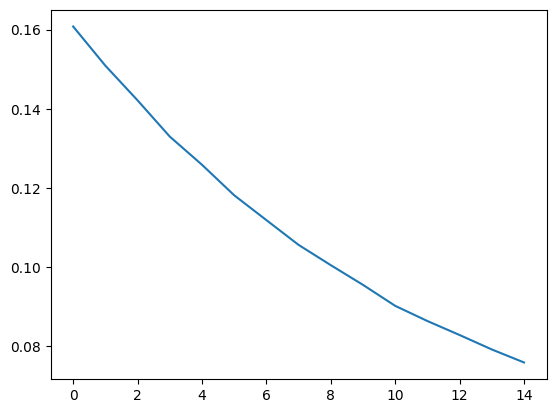

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
# plt.ylim(0, 0.25*1e8)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [ ]:
torch.save(model, 'model.pt')

load_model = torch.load('model.pt')
load_model

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=6, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=6, out_features=4, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
df.iloc[:1]

,age,sex,bmi,children,smoker,expenses
0,0.021739,1,0.320755,0,1,0.251611


In [ ]:
X.iloc[:1]

,age,sex,bmi,children,smoker
0,0.021739,1,0.320755,0,1


In [ ]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.0217, 1.0000, 0.3208, 0.0000, 1.0000]])
torch.Size([1, 5])


In [ ]:
load_model(X_data) # порахує градієнти

tensor([[0.3827]], grad_fn=<AddmmBackward0>)

In [ ]:
with torch.no_grad(): # без градієнтів
  print(load_model(X_data))

tensor([[0.3827]])
